In [1]:
import xarray as xr
import geopandas as gpd
import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs # for projection

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Code Citation: Huang, B., C. Liu, V. Banzon, E. Freeman, G. Graham, B. Hankins, T. Smith, and H.-M. Zhang, 2020: Improvements of the Daily Optimum Interpolation Sea Surface Temperature (DOISST) Version 2.1, Journal of Climate, 34, 2923-2939. doi: 10.1175/JCLI-D-20-0166.1

In [27]:
ds = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/icec.mon.mean.nc', 
                     chunks={'time':'500MB'})

ds

<xarray.Dataset>
Dimensions:  (time: 517, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2024-09-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    icec     (time, lat, lon) float32 dask.array<chunksize=(120, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
ds = ds.sel(lat=slice(66,90),lon=slice(0,360))

In [ ]:
ds.to_netcdf('icec_data.nc', format='NETCDF3_64BIT')

In [4]:
ds = xr.open_dataset('icec_data.nc', decode_times=True)
icec = ds['icec']

In [ ]:
sea_routes = gpd.read_file('Sea Routes.geojson')
sea_routes = sea_routes.drop(columns=['Id','OBJECTID'])
sea_routes['numbers'] = [1,2,3]
sea_routes

,Name,Shape_Leng,geometry,numbers
0,Northwest Passage,7689.630315,"LINESTRING (-168.83320 59.34944, -167.33377 62...",1
1,Northern Sea Route,7576.681873,"MULTILINESTRING ((180.00000 70.32357, 179.0842...",2
2,Transpolar,7137.175384,"LINESTRING (-169.78554 60.27749, -168.41041 62...",3


In [8]:
#Reproject data onto North Pole Azimuthal Equidistant CRS for accurate plotting: https://gis.stackexchange.com/questions/387091/how-to-plot-coordinate-system-from-epsg-4326-on-north-pole-centered-map-in-pytho
sea_routes_reproj = sea_routes.to_crs('+proj=aeqd +lat_0=90')
sea_routes_reproj.crs

<Projected CRS: +proj=aeqd +lat_0=90 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Modified Azimuthal Equidistant
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

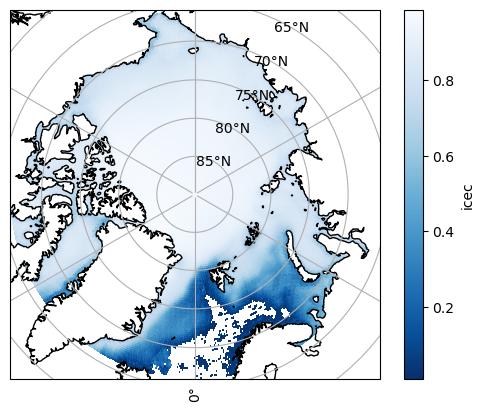

In [7]:
#Time averaged map just to see the data and make sure I have what I expect
proj = ccrs.NorthPolarStereo()
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

# Gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.coastlines()

time_avg_icec = ds['icec'].mean(dim='time')
time_avg_icec.plot(subplot_kws=dict(projection=proj),transform=trans,cmap='Blues_r')

In [8]:
lost_data = icec.sel(lat=slice(66,78),lon=slice(0,35))

icec_interp = lost_data.interpolate_na(dim='lat', method='nearest')

<GeoAxes: xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

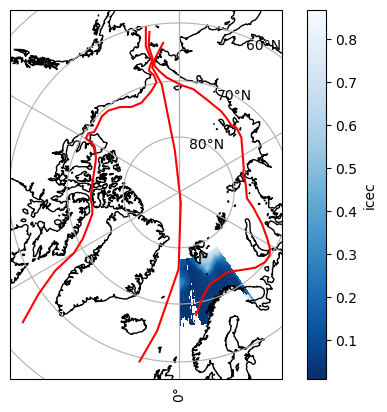

In [9]:
#Time averaged map just to see the data and make sure I have what I expect
proj = ccrs.NorthPolarStereo()
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

# Gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.coastlines()

time_avg_icec = icec_interp.mean(dim='time')
time_avg_icec.plot(subplot_kws=dict(projection=proj),transform=trans,cmap='Blues_r')
sea_routes_reproj.plot(ax=ax,color='red')

<GeoAxes: xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

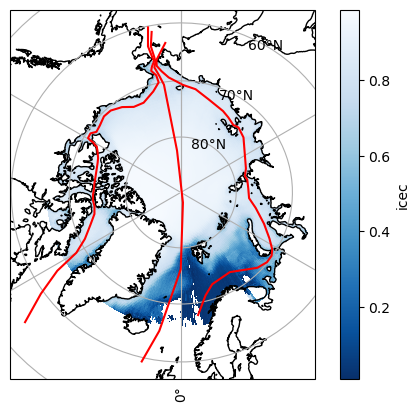

In [10]:
icec_final = icec.fillna(icec_interp)

proj = ccrs.NorthPolarStereo()
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

# Gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.coastlines()

time_avg_icec = icec_final.mean(dim='time')
time_avg_icec.plot(subplot_kws=dict(projection=proj),transform=trans,cmap='Blues_r')
sea_routes_reproj.plot(ax=ax,color='red')

In [11]:
icec_final.to_netcdf('icec_final.nc', format='NETCDF3_64BIT')
icec_final = xr.open_dataset('icec_final.nc', decode_times=True)

In [ ]:
mask_3D = regionmask.mask_3D_geopandas(sea_routes, icec_final, numbers='numbers', use_cf=True)
nwp = mask_3D.sel(region=1)
nsr = mask_3D.sel(region=2)

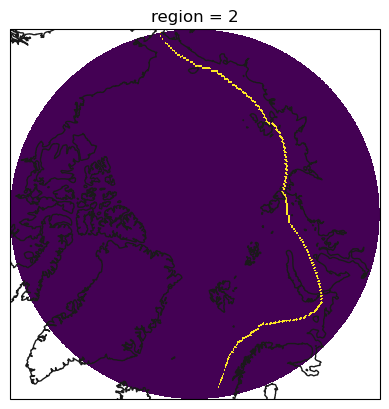

In [13]:
f, ax = plt.subplots(subplot_kw=dict(projection=proj))

nsr.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)

ax.coastlines(color="0.1");

In [14]:
nwp_data = icec_final.where(nwp == True)
nsr_data = icec_final.where(nsr == True)

In [15]:
nwp_data

<xarray.Dataset>
Dimensions:  (time: 516, lat: 96, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2024-08-01
  * lat      (lat) float32 66.12 66.38 66.62 66.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    region   int64 1
Data variables:
    icec     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

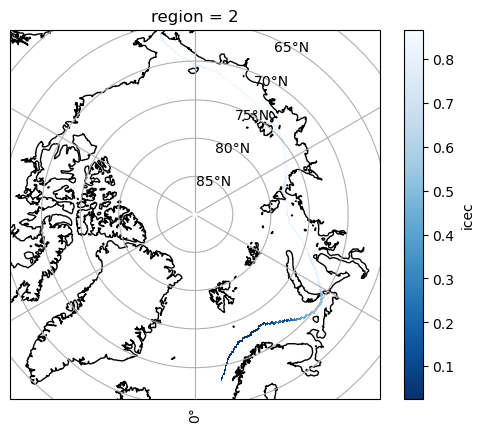

In [16]:
proj = ccrs.NorthPolarStereo()
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

# Gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.coastlines()

#mask_3D.sel(region=1).plot(ax=ax)
time_avg_icec = nsr_data['icec'].mean(dim='time')
time_avg_icec.plot(subplot_kws=dict(projection=proj),transform=trans,cmap='Blues_r')
#sea_routes_reproj.plot(ax=ax,color='red')

In [17]:
nwp_data.to_netcdf('nwp_data.nc', format='NETCDF3_64BIT')
nsr_data.to_netcdf('nsr_data.nc', format='NETCDF3_64BIT')